In [1]:
import numpy as np
from pytisean import tiseanio
from datasets import *
from pendulum import *
from rk4 import rk4
from matplotlib import pyplot as plt
from curvature import *
from subprocess import call
import pandas as pd

params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)

In [2]:
def plot_d2_with_slopes(d2,dims, filename, limits, start_dim=1):
    
    data_per_dim = int(d2.shape[0] / dims)
    plt.figure(figsize=(12,8), dpi=300)
    for dim in range(start_dim,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        
        plt.plot(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1], '.', 
                 label=r'm=%d, d2=%.2f' % (dim, p[0]))
                 #label=r'm=%d, d2=%.2f $\pm$ %.2f' % (dim, p[0], np.sqrt(COV[0][0])))
       
        x_coord = np.arange(limits[0],limits[1],0.1)
        y_coord = x_coord * p[0] + p[1]
        print(dim, p[0])
        
        #plt.plot(x_coord, y_coord, color='black')

    plt.axvline(x=limits[0], color='black', markersize=.01)
    plt.axvline(x=limits[1], color='black', markersize=.01)
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'log ($\epsilon$)', fontsize=20)
    plt.ylabel(r'log (C($\epsilon$))', fontsize=20)    
    plt.legend(prop={'size': 16})
    plt.savefig(filename)
    plt.show()

def plot_d2(d2,dims, filename, limits):
    
    data_per_dim = int(d2.shape[0] / dims)
    plt.figure(figsize=(12,8))
    for dim in range(1,dims+1):
        
        plt.plot(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1], '.', 
                 label=r'm=%d' % (dim))
       
    plt.xlabel(r'log ($\epsilon$)', fontsize=16)
    plt.ylabel(r'log (C($\epsilon$))', fontsize=16)    
    plt.legend(prop={'size': 16})
    plt.savefig(filename)
    plt.show()

    
def fit_slopes(d2, dims, limits):
    data_per_dim = int(d2.shape[0] / dims)
    print(limits)
    for dim in range(1,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        print(r'embedding dim={}, correlation dimension={}+/-{}'.format(dim, p[0], np.sqrt(COV[0][0])))
        
def moving_average(x, window = 4):
    
    s = pd.Series(x)
    s_ma = s.rolling(window).mean()

    return (np.array(s_ma)[window:])
    
    

# Pendulum


In [3]:
def data_pendulum_omega(noise_level, step_size, num_points):

    changeA(0.91);
    [data,t] = rk4(derivative, [3.14, 50], 0, step_size, int(num_points));
    #[data,t] = rk4(derivative, [3.14, 50], 0, 0.05, 50000);
    
    #transient = int(data.shape[0]/100)
    transient = 100000
    data = data[transient:,:];
    t = t[transient:]
    max_val = np.max((data[:,1])) - np.min((data[:,1])) 
    series = data[:,1] + noise_level*max_val*(np.random.random((data.shape[0])) - .5)

    return [t, data, series];

factor = 1
step_size = 0.001
num_points = 1100000 

t1, data1, x1 = data_pendulum_omega(0.0, step_size / factor, num_points * factor)

data1 = data1[::factor,:]
x1 = x1[::factor]
t1 = t1[::factor]

print(data1.shape, t1.shape)

(1100000, 2)
(1000000, 2) (1000000,)


In [4]:
ds_rate = 1
theiler_multiplier = 1

data = data1[::ds_rate,:]
x = x1[::ds_rate]
t = t1[::ds_rate]

print(data.shape, t.shape)

(1000000, 2) (1000000,)


606
Additional non-data files were created
3 2.2239413205755123


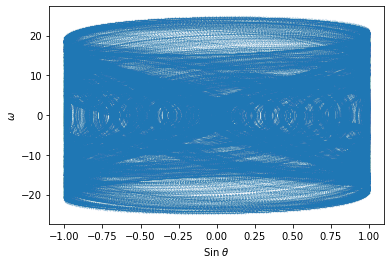

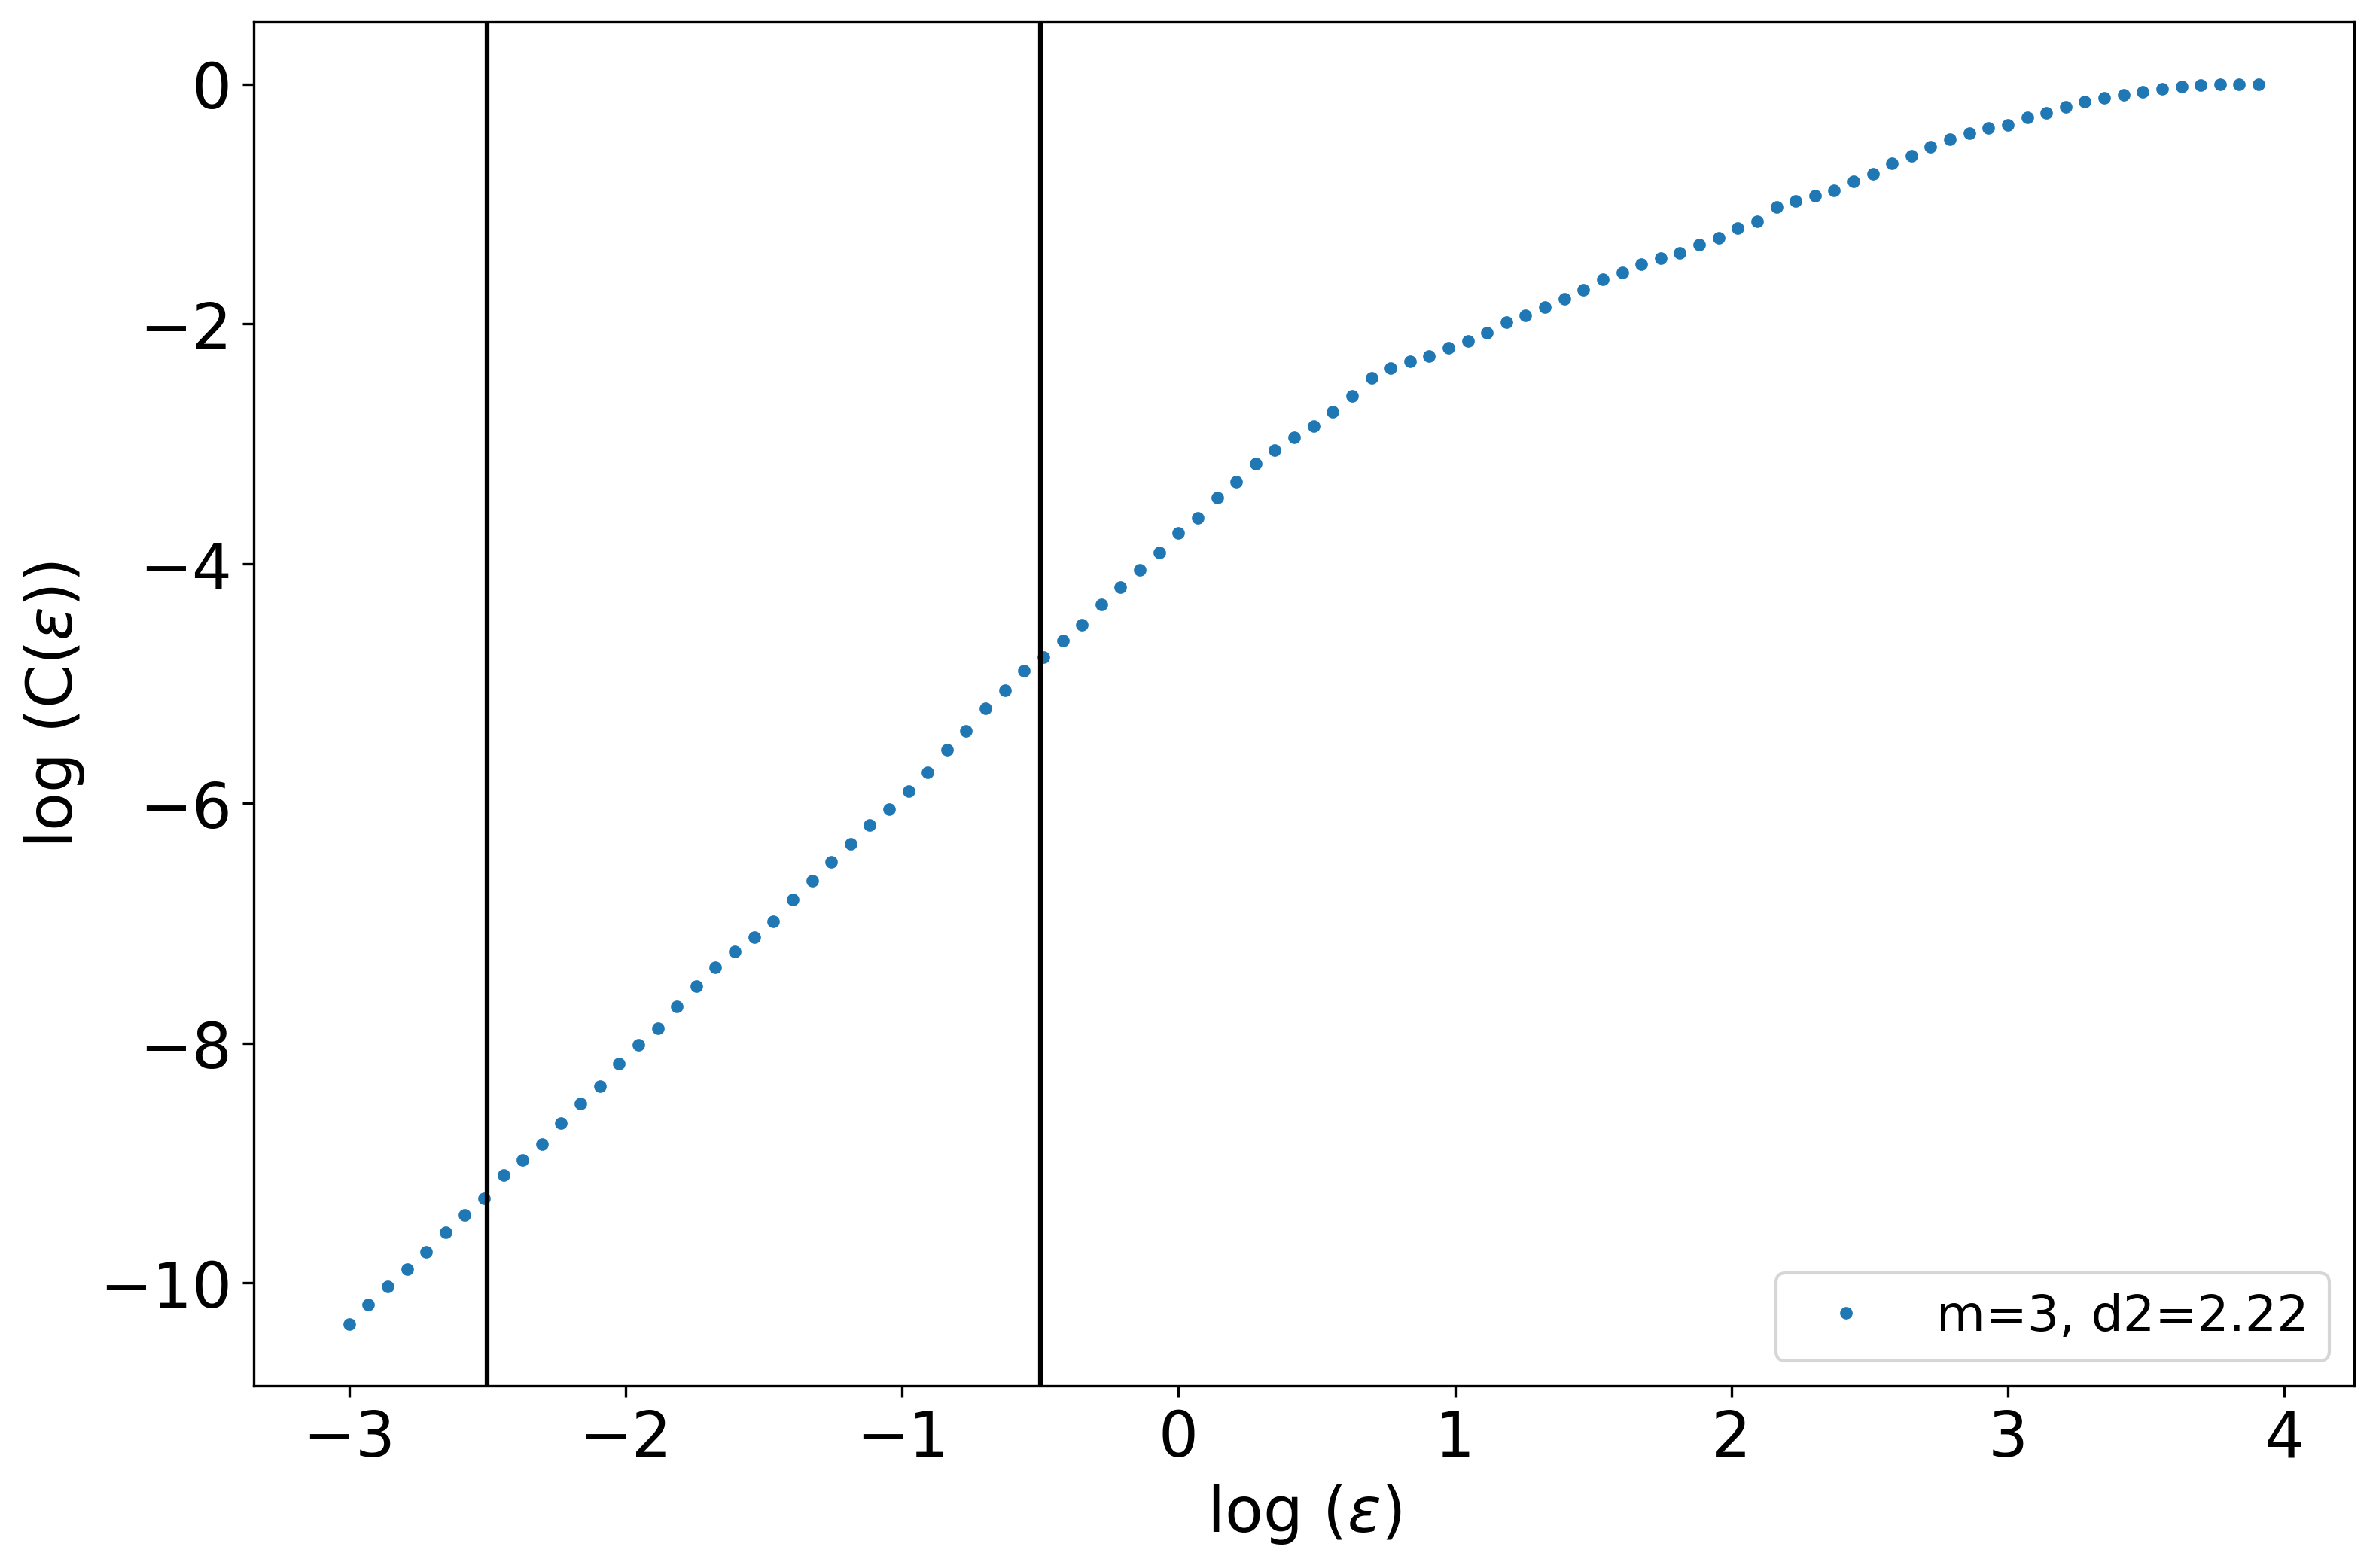

[-2.5, -0.5]
embedding dim=1, correlation dimension=0.8250120776925463+/-0.0031077081418586254
embedding dim=2, correlation dimension=1.778853454906721+/-0.0051660282293050416
embedding dim=3, correlation dimension=2.2239413205755123+/-0.008549222771169231


In [5]:
beta = 0.25
m = 0.1
l = 0.1
g = 9.8
A = 0.75
alpha = np.sqrt(g/l)*0.75

plt.figure()
plt.plot(np.sin(data[:,0]), data[:,1], '.', markersize=.1)
plt.xlabel(r'Sin $\theta$')
plt.ylabel(r'$\omega$')
plt.savefig('./d2_figures_paper/chaotic_pendulum_state_space_ds_rate_{}.png'.format(ds_rate))

data_t = np.zeros((data.shape[0], 3))
data_t[:,0] = np.sin(data[:,0])
data_t[:,1] = data[:,1]
data_t[:,2] = np.sin(alpha*t)

limits=[-2.5,-.5]
dims = 3
theiler_window = int(2.718**limits[-1]/step_size/ds_rate) * theiler_multiplier
print(theiler_window)
corr = tiseanio('d2','-M','3,1','-c','1,2,3', '-t', theiler_window, data=data_t, silent=True)
c2 = corr[0]['c2']
#log_c2 = np.concatenate((np.log(c2[:,0]).reshape(-1,1), np.log(c2[:,1]).reshape(-1,1)), axis=1)
log_c2 = np.log(c2)
plot_d2_with_slopes(log_c2, dims, './d2_figures_paper/chaotic_pendulum_full_ds_rate_{}_limits_{}_{}.png'.format(ds_rate, limits[0], limits[1]), limits, 
                    start_dim=3)
fit_slopes(log_c2, dims, limits)


In [6]:
x_ma = moving_average(x, window=20)
print(x)
print(x_ma)

[ 22.72453138  22.76629688  22.80548875 ... -17.4665092  -17.47309443
 -17.47854185]
[ 22.98542985  22.99882739  23.00946538 ... -17.33714633 -17.3529206
 -17.36779042]


In [7]:
tau_max = int(400 / ds_rate)
mutual, err = tiseanio('mutual', '-D', tau_max, data=x)
#embed, err = tiseanio('delay', '-m', 2, '-d', tau, data=lorenzTS, silent=True)

def get_menger_tau(data, tau_max):
    menger = [];
    dim = 2
    tau_avg = 1
    n_neighbors = 0
    menger_params = np.array([data.shape[0], dim, tau_max, tau_avg, n_neighbors])
    np.savetxt('menger_params.txt', menger_params)
    np.savetxt('menger_in.txt', data);
    np.savetxt('menger_params.txt', menger_params, fmt="%d")
    
    call(["./menger", "menger_in.txt", "menger_out.txt", "menger_params.txt"])
    menger_data = np.loadtxt("menger_out.txt");
    return menger_data[:,0], menger_data[:,1]

[menger_mean, menger_var] = get_menger_tau(x_ma, tau_max)


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

mutual: Estimates the time delayed mutual information
	of the data set

Using /tmp/pytisean_temp_2020-04-12-19-07-41_33egzosf/inFile as datafile, reading column 1
Use 1000000 lines.
Opened /tmp/pytisean_temp_2020-04-12-19-07-41_33egzosf/outFile for writing



No handles with labels found to put in legend.


(401, 2) (399,)


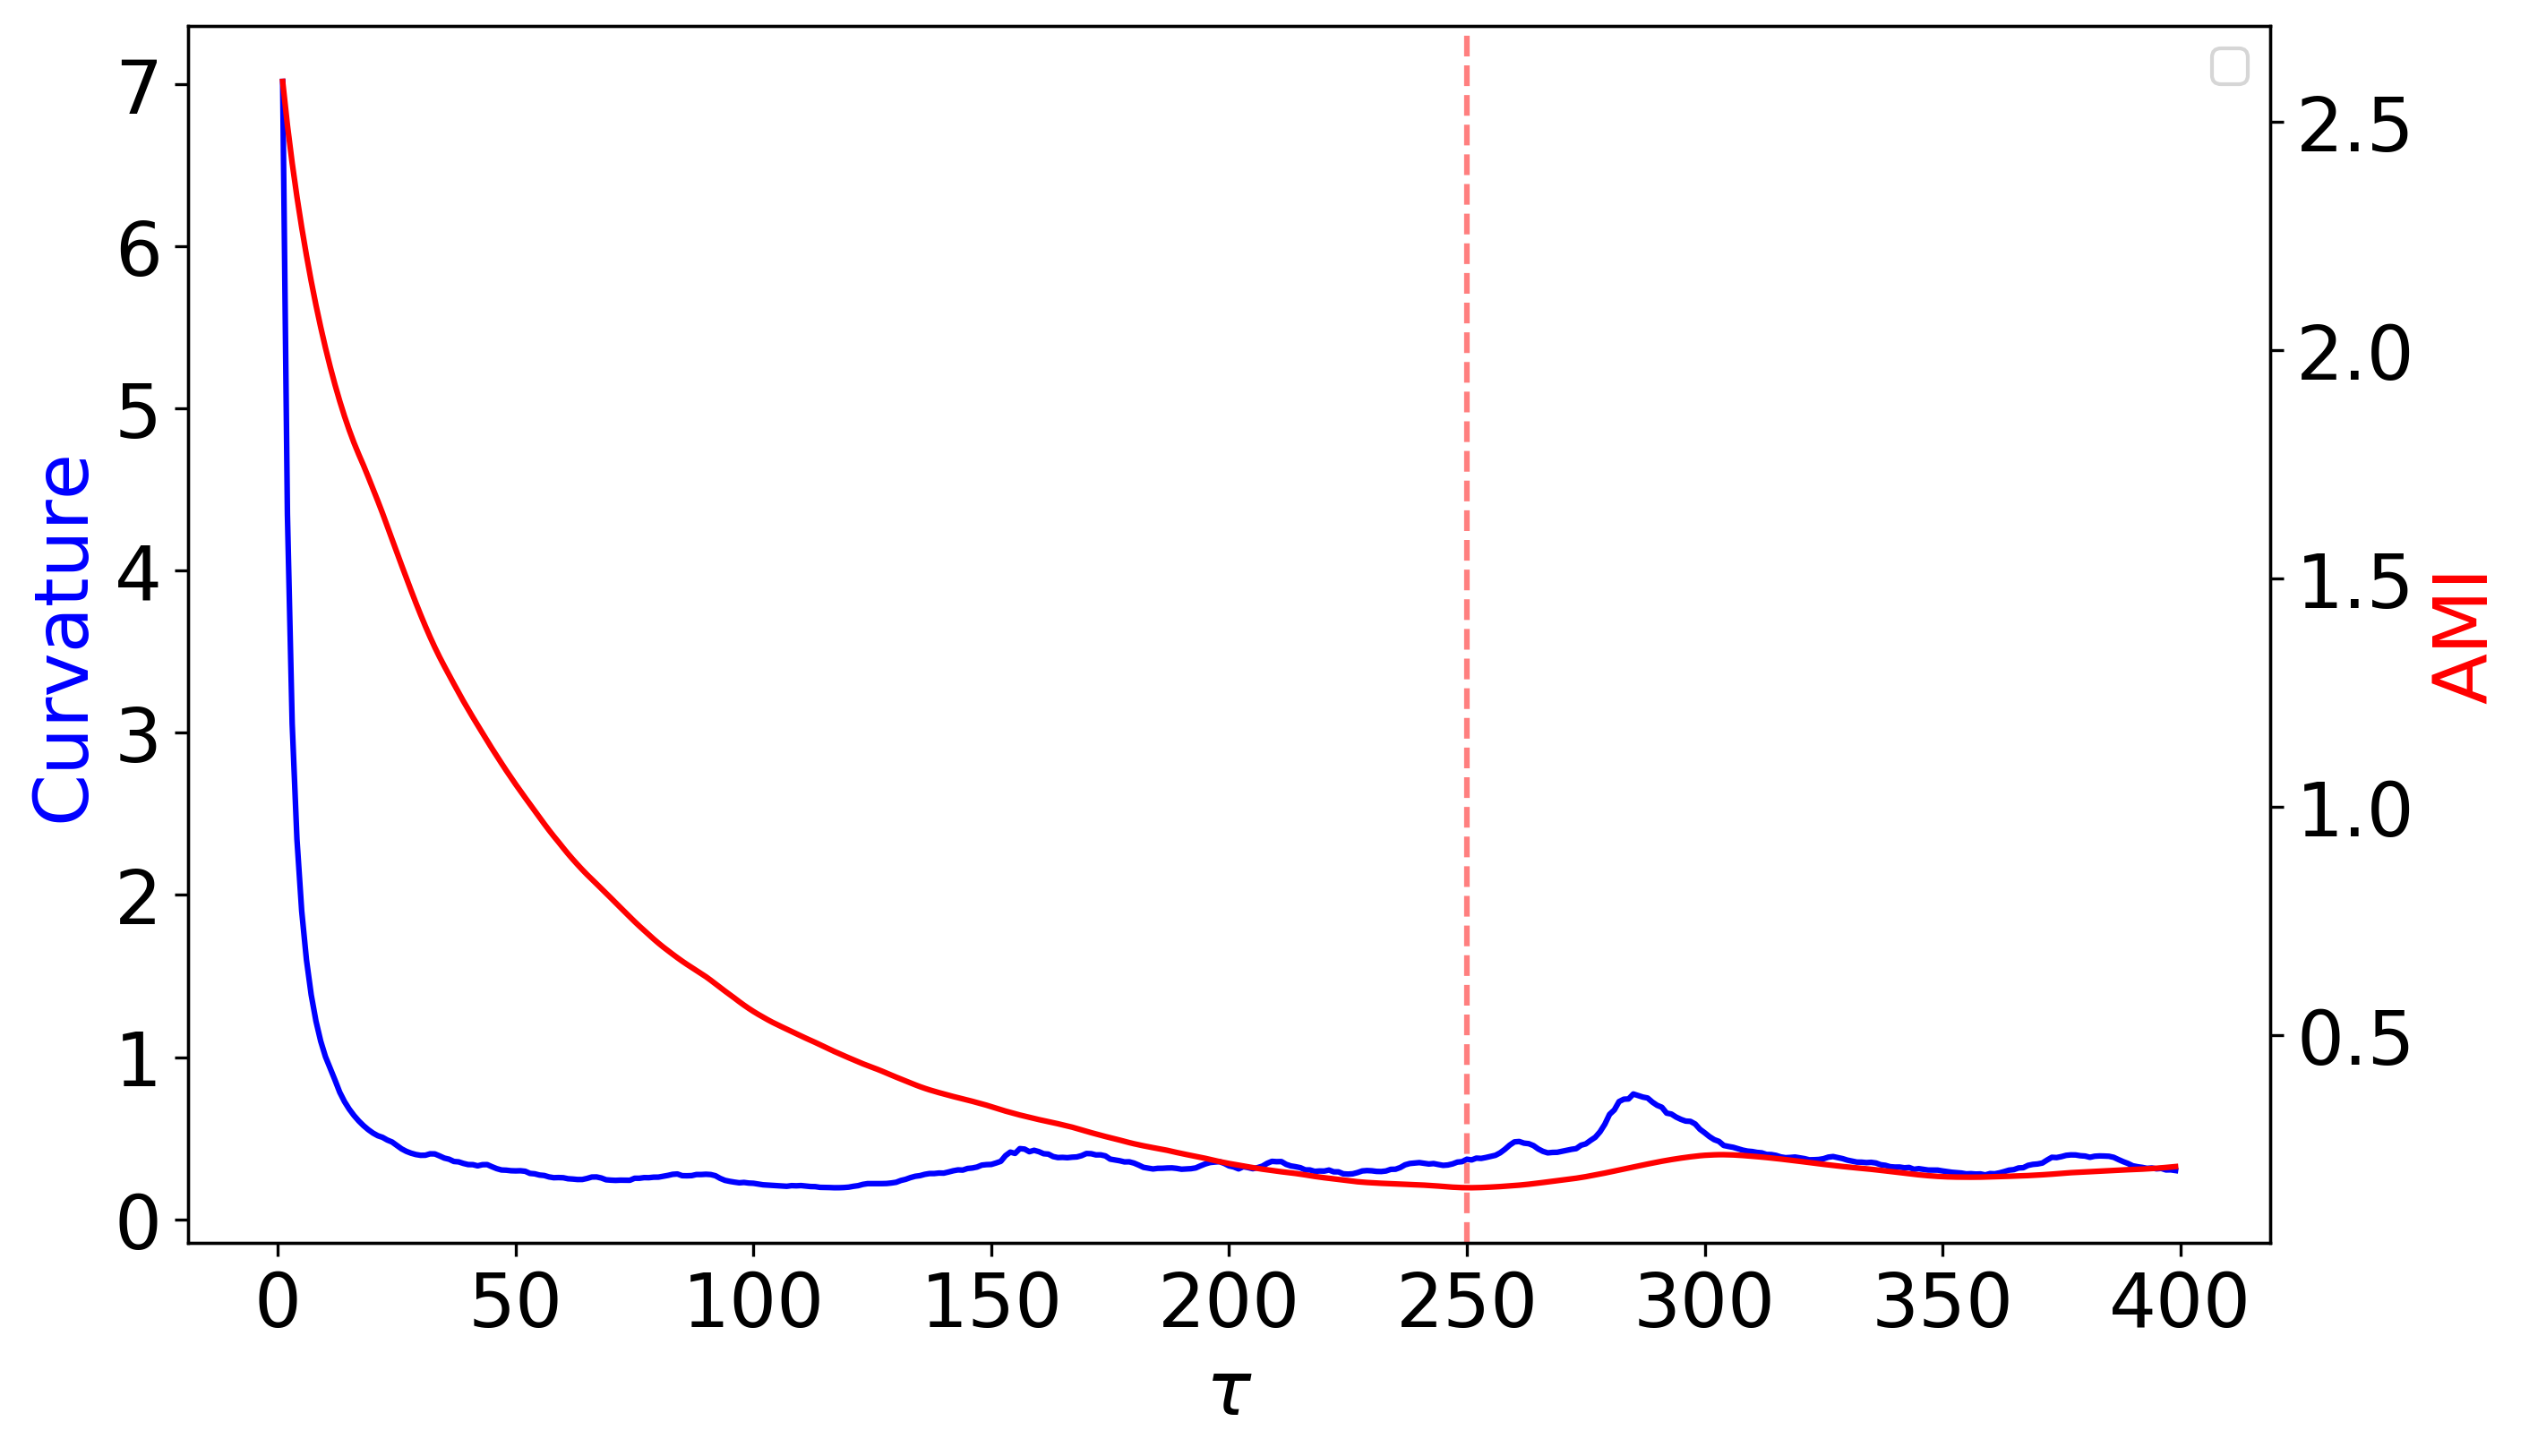

In [8]:
tau = 3
print(mutual.shape, menger_mean.shape)

xrange = np.arange(1, tau_max)
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)

#plt.plot(menger_var, label = 'curvature variance')
ax1.plot(xrange, menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
ax1.set_ylabel(r'Curvature', color='b', fontsize=20)
ax2 = ax1.twinx()
#ax1.axvline(x = 120, color='b', linestyle='--', alpha=0.5)
#ax1.axvline(x = 70, color='b', linestyle='--', alpha=0.5)
ax2.axvline(x = 250, color='r', linestyle='--', alpha=0.5)
ax2.plot(xrange, mutual[1:-1,1], color = 'r')
ax2.set_ylabel(r'AMI', color='r', fontsize=20)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('./d2_figures_paper/chaotic_pendulum_measures_vs_tau_ds_rate_{}.png'.format(ds_rate))

#print(menger_mean[::5])

No handles with labels found to put in legend.



TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

corr: Estimates the autocorrelations of a data set

Using /tmp/pytisean_temp_2020-04-14-22-13-50_bp6essdj/inFile as datafile, reading column 1
Use 1000000 lines.
Opened /tmp/pytisean_temp_2020-04-14-22-13-50_bp6essdj/outFile for writing



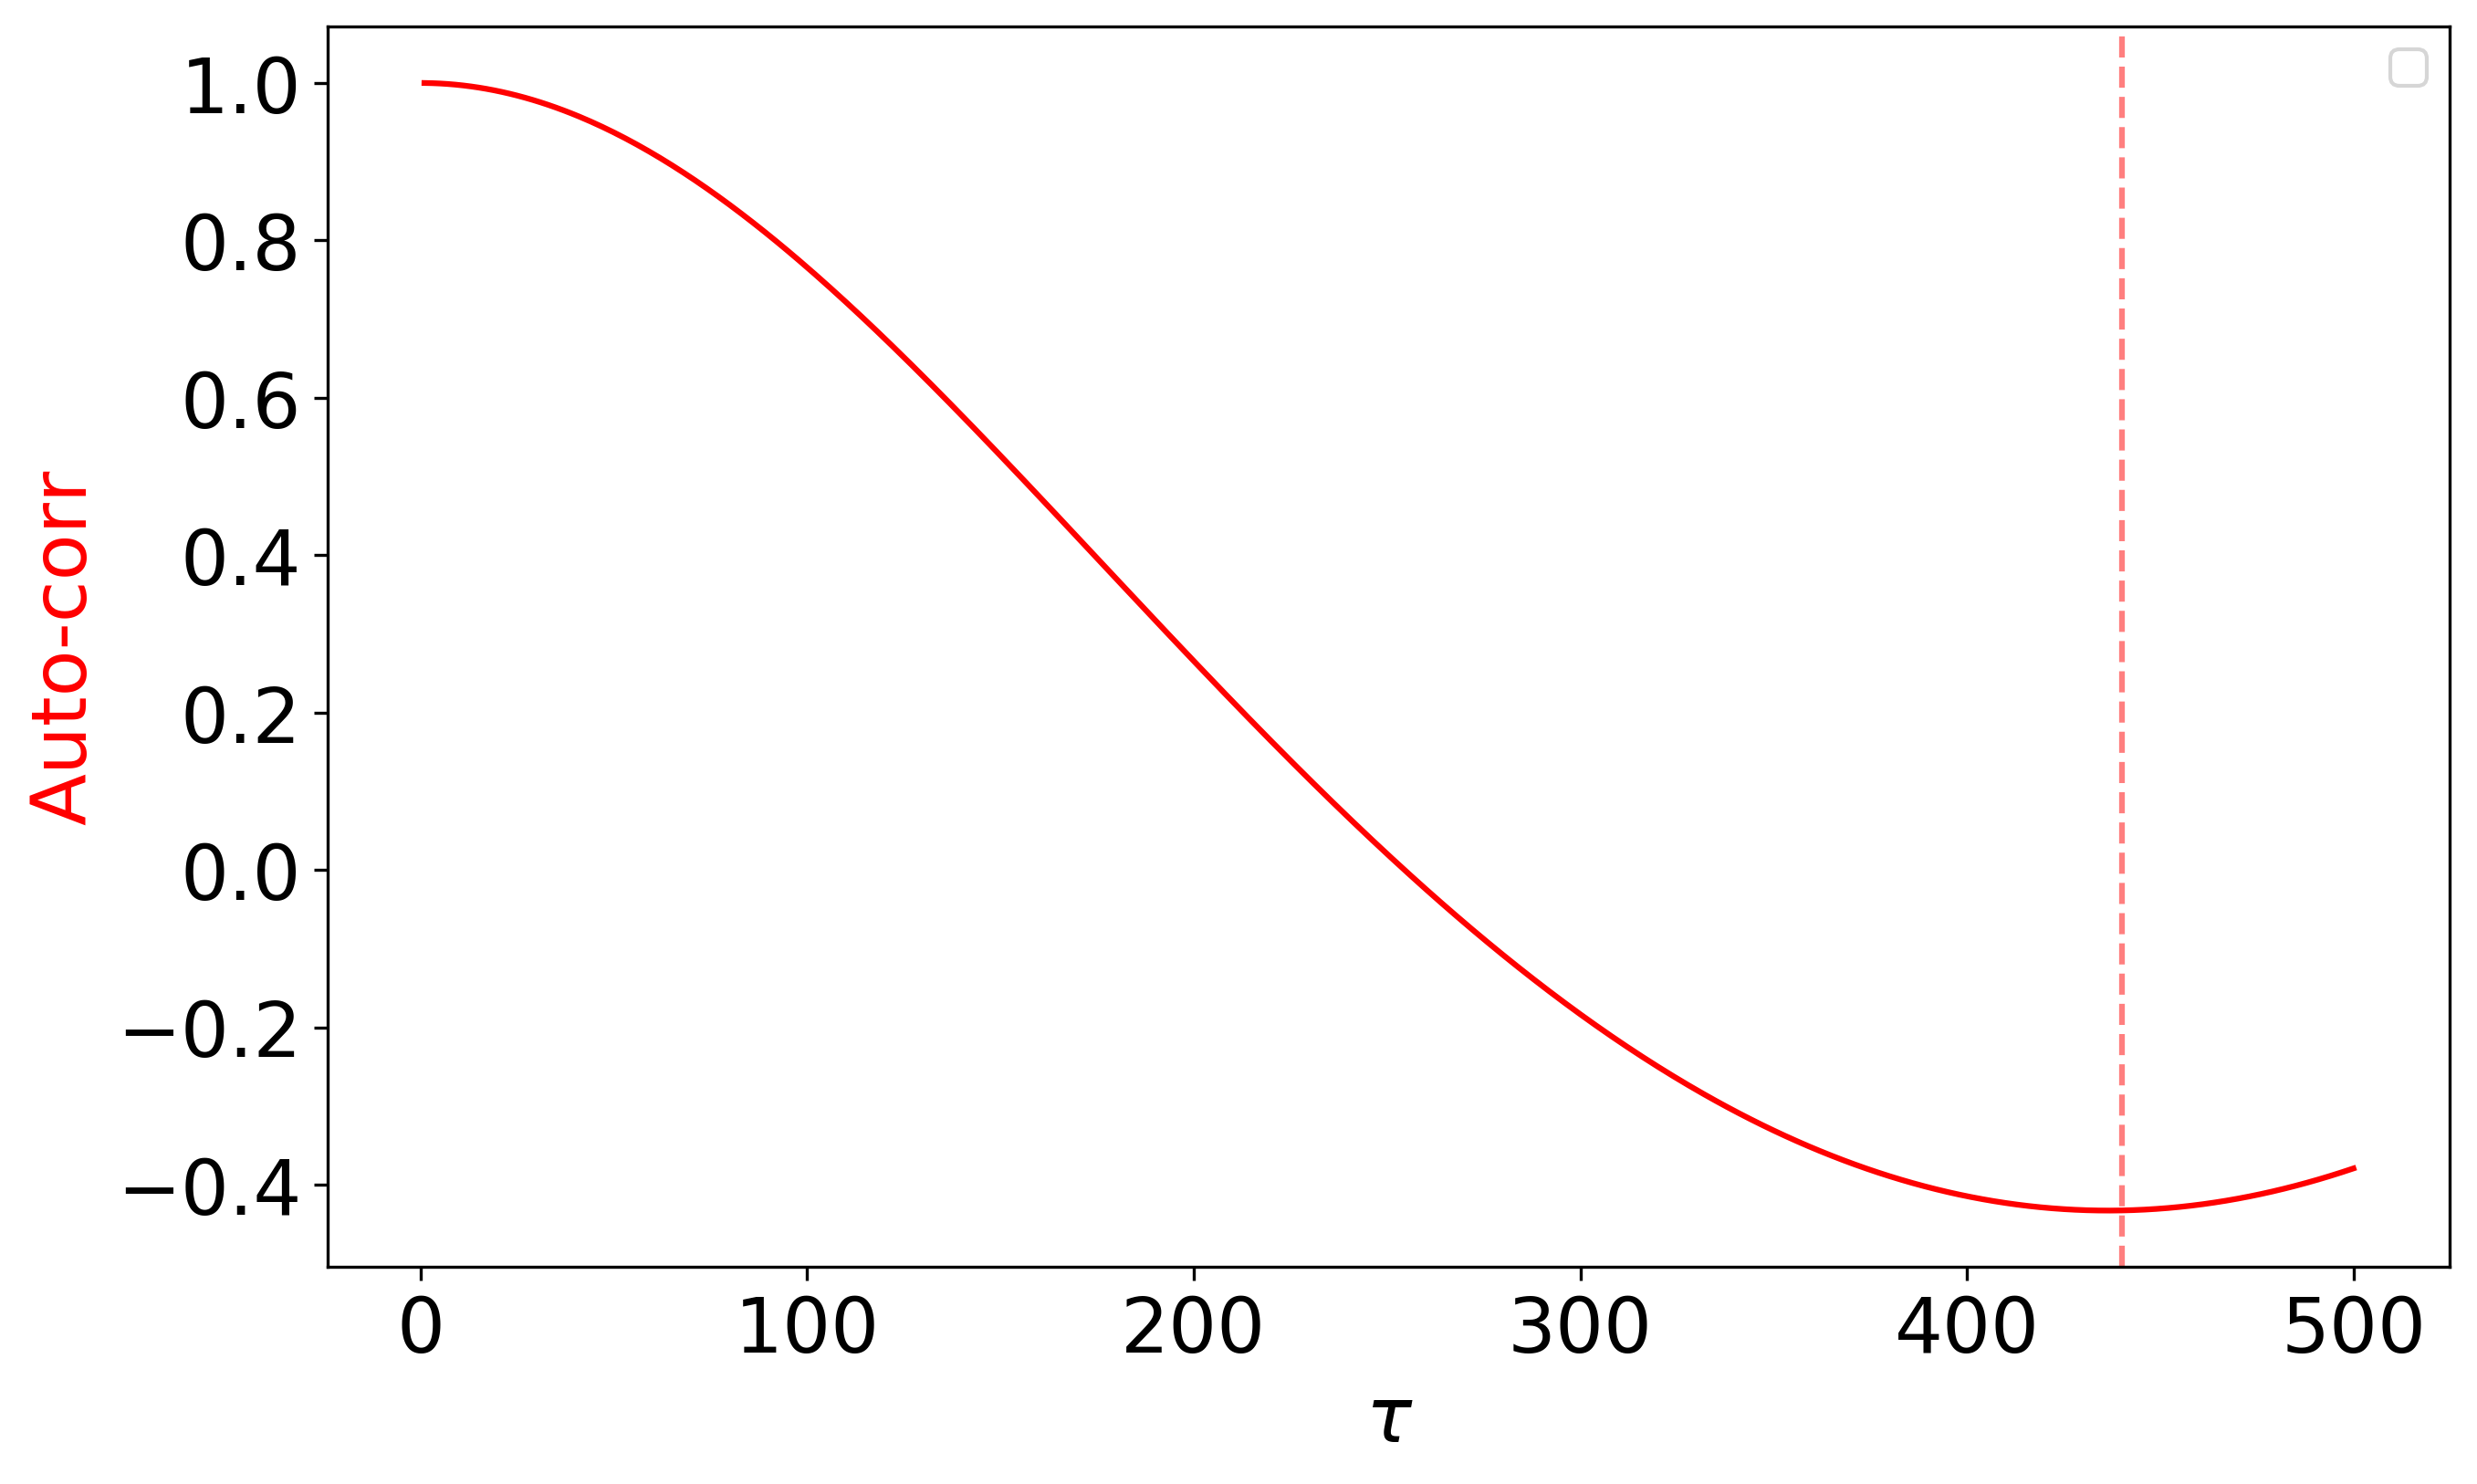

In [18]:
corr_ma, err = tiseanio('corr', '-D', 500, data=x)
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)

#plt.plot(menger_var, label = 'curvature variance')
#ax1.plot(np.arange(1,tau_max), menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
ax1.set_ylabel(r'Curvature', color='b', fontsize=20)
#ax2 = ax1.twinx()
ax1.plot(corr_ma[1:,0], corr_ma[1:,1], color = 'r')
ax1.set_ylabel(r'Auto-corr', color='r', fontsize=20)
#ax1.axvline(x = 250, color='b', linestyle='--', alpha=0.5)
ax1.axvline(x = 440, color='r', linestyle='--', alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('d2_figures_paper/corr/chaotic_pendulum_measures_vs_tau_ds_rate_{}.png'.format(ds_rate))#
#plt.savefig('lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))

# Chaotic Pendulum tau = 20 (Curvature)

1648
Additional non-data files were created
1 0.989144707021692
2 1.8797228917593984
3 2.2417303403475364
4 2.274083098793591
5 2.2497752835368465
6 2.2096375100608974
7 2.176849350502082


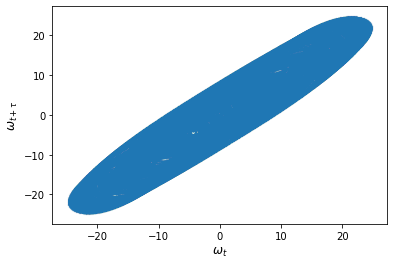

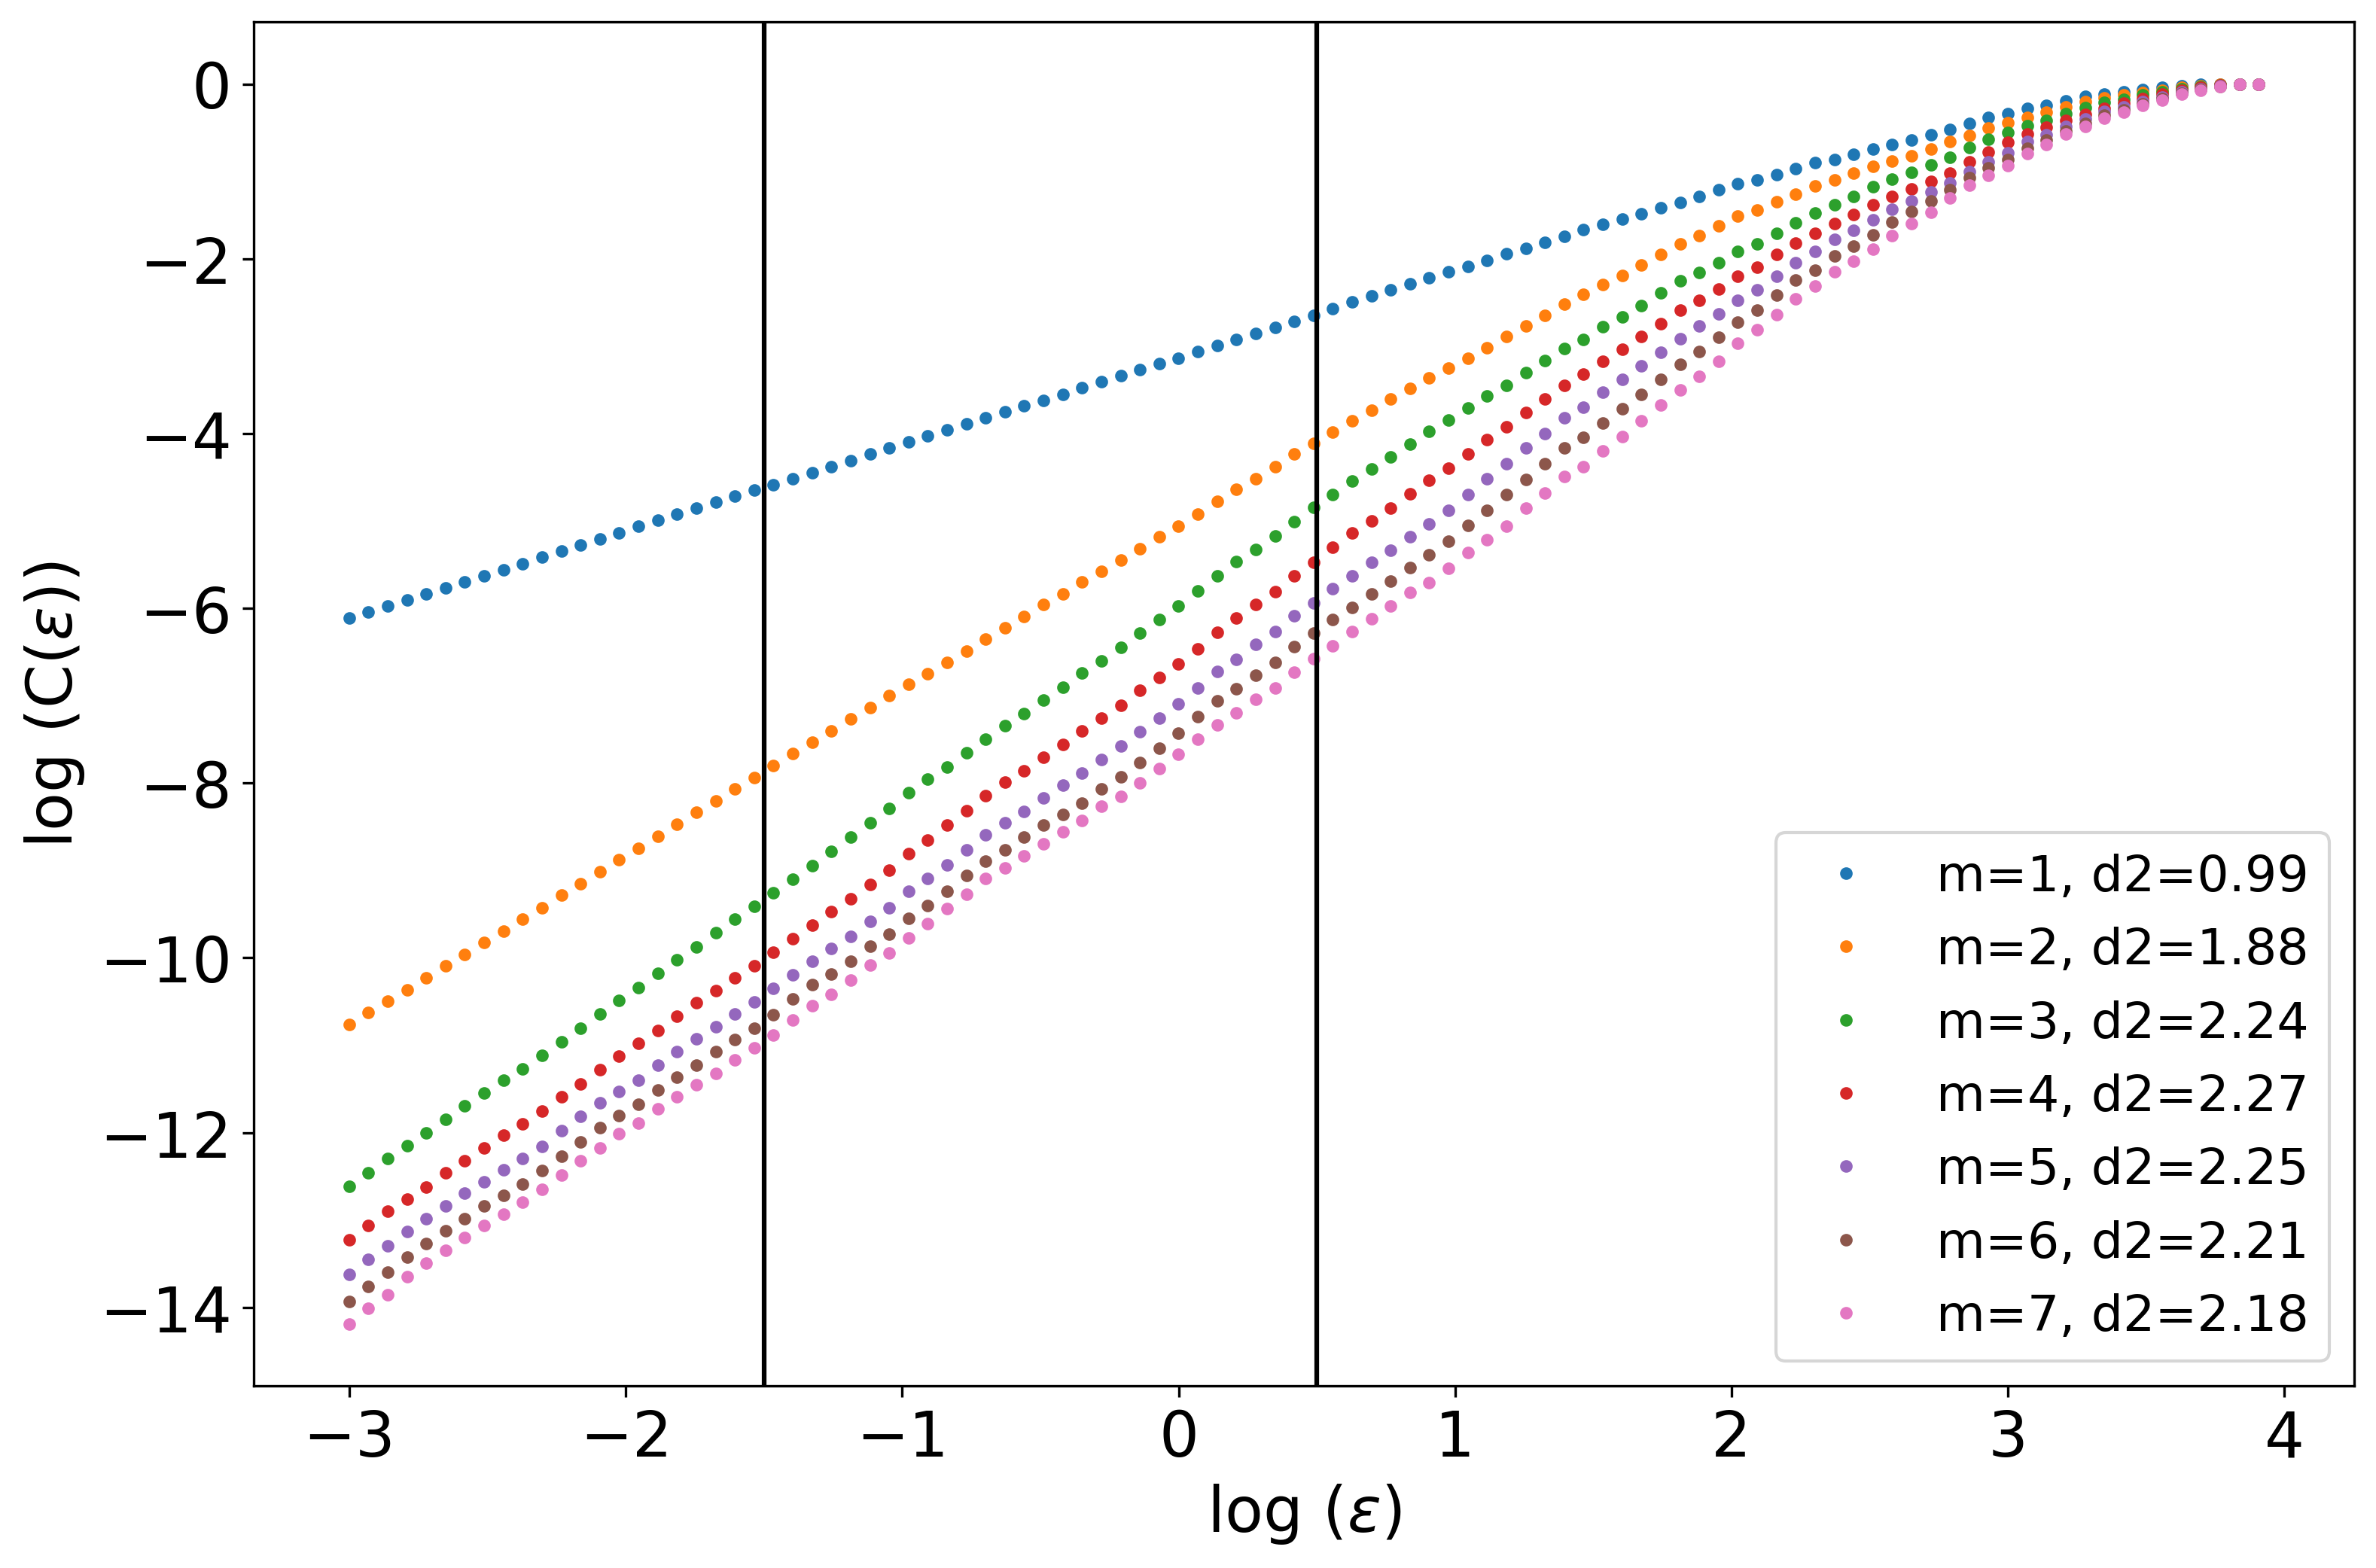

[-1.5, 0.5]
embedding dim=1, correlation dimension=0.989144707021692+/-0.0008509608632689909
embedding dim=2, correlation dimension=1.8797228917593984+/-0.003084688994509012
embedding dim=3, correlation dimension=2.2417303403475364+/-0.005504105732085889
embedding dim=4, correlation dimension=2.274083098793591+/-0.007031172482354472
embedding dim=5, correlation dimension=2.2497752835368465+/-0.007725799801307406
embedding dim=6, correlation dimension=2.2096375100608974+/-0.01035177248243554
embedding dim=7, correlation dimension=2.176849350502082+/-0.00984423830571717


In [51]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]
#tau = 25
#tau = 22
tau = 50

plt.figure()
plt.plot(x[:-tau], x[tau:], '.', markersize=.1)
plt.xlabel(r'$\omega_{t}$', fontsize=12)
plt.ylabel(r'$\omega_{t+\tau}$', fontsize=12)
plt.savefig('chaotic_pendulum_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

#limits = [-1.5,.5]
limits = [-1.5, .5]

#series = data_lorenz(0,n=n,tmax=trans)
dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate) * theiler_multiplier
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims), '-t', theiler_window, data=x, silent=True)

c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2_with_slopes(log_c2, dims, './d2_figures_paper/chaotic_pendulum_curvature_{}_ds_rate_{}_limits_{}_{}.png'.format(tau, ds_rate, limits[0], limits[1]), limits)

#limits = [-1.2,1]
#plot_d2_with_slopes(log_c2, dims, 'chaotic_pendulum_curvature_{}_ds_rate_{}.png'.format(tau, ds_rate), limits)

#plot_d2(log_c2, dims, '/tmp/chaotic_pendulum_curvature_100.png', limits)
fit_slopes(log_c2, dims, limits)

# Chaotic Pendulum tau = 50 (Mutual)

0.001
2718
Additional non-data files were created
1 0.9866603922842304
2 1.8866727851679084
3 2.1134332873547232
4 2.1790244071394493
5 2.1976295875513188
6 2.239464470492182
7 2.2133922882701036


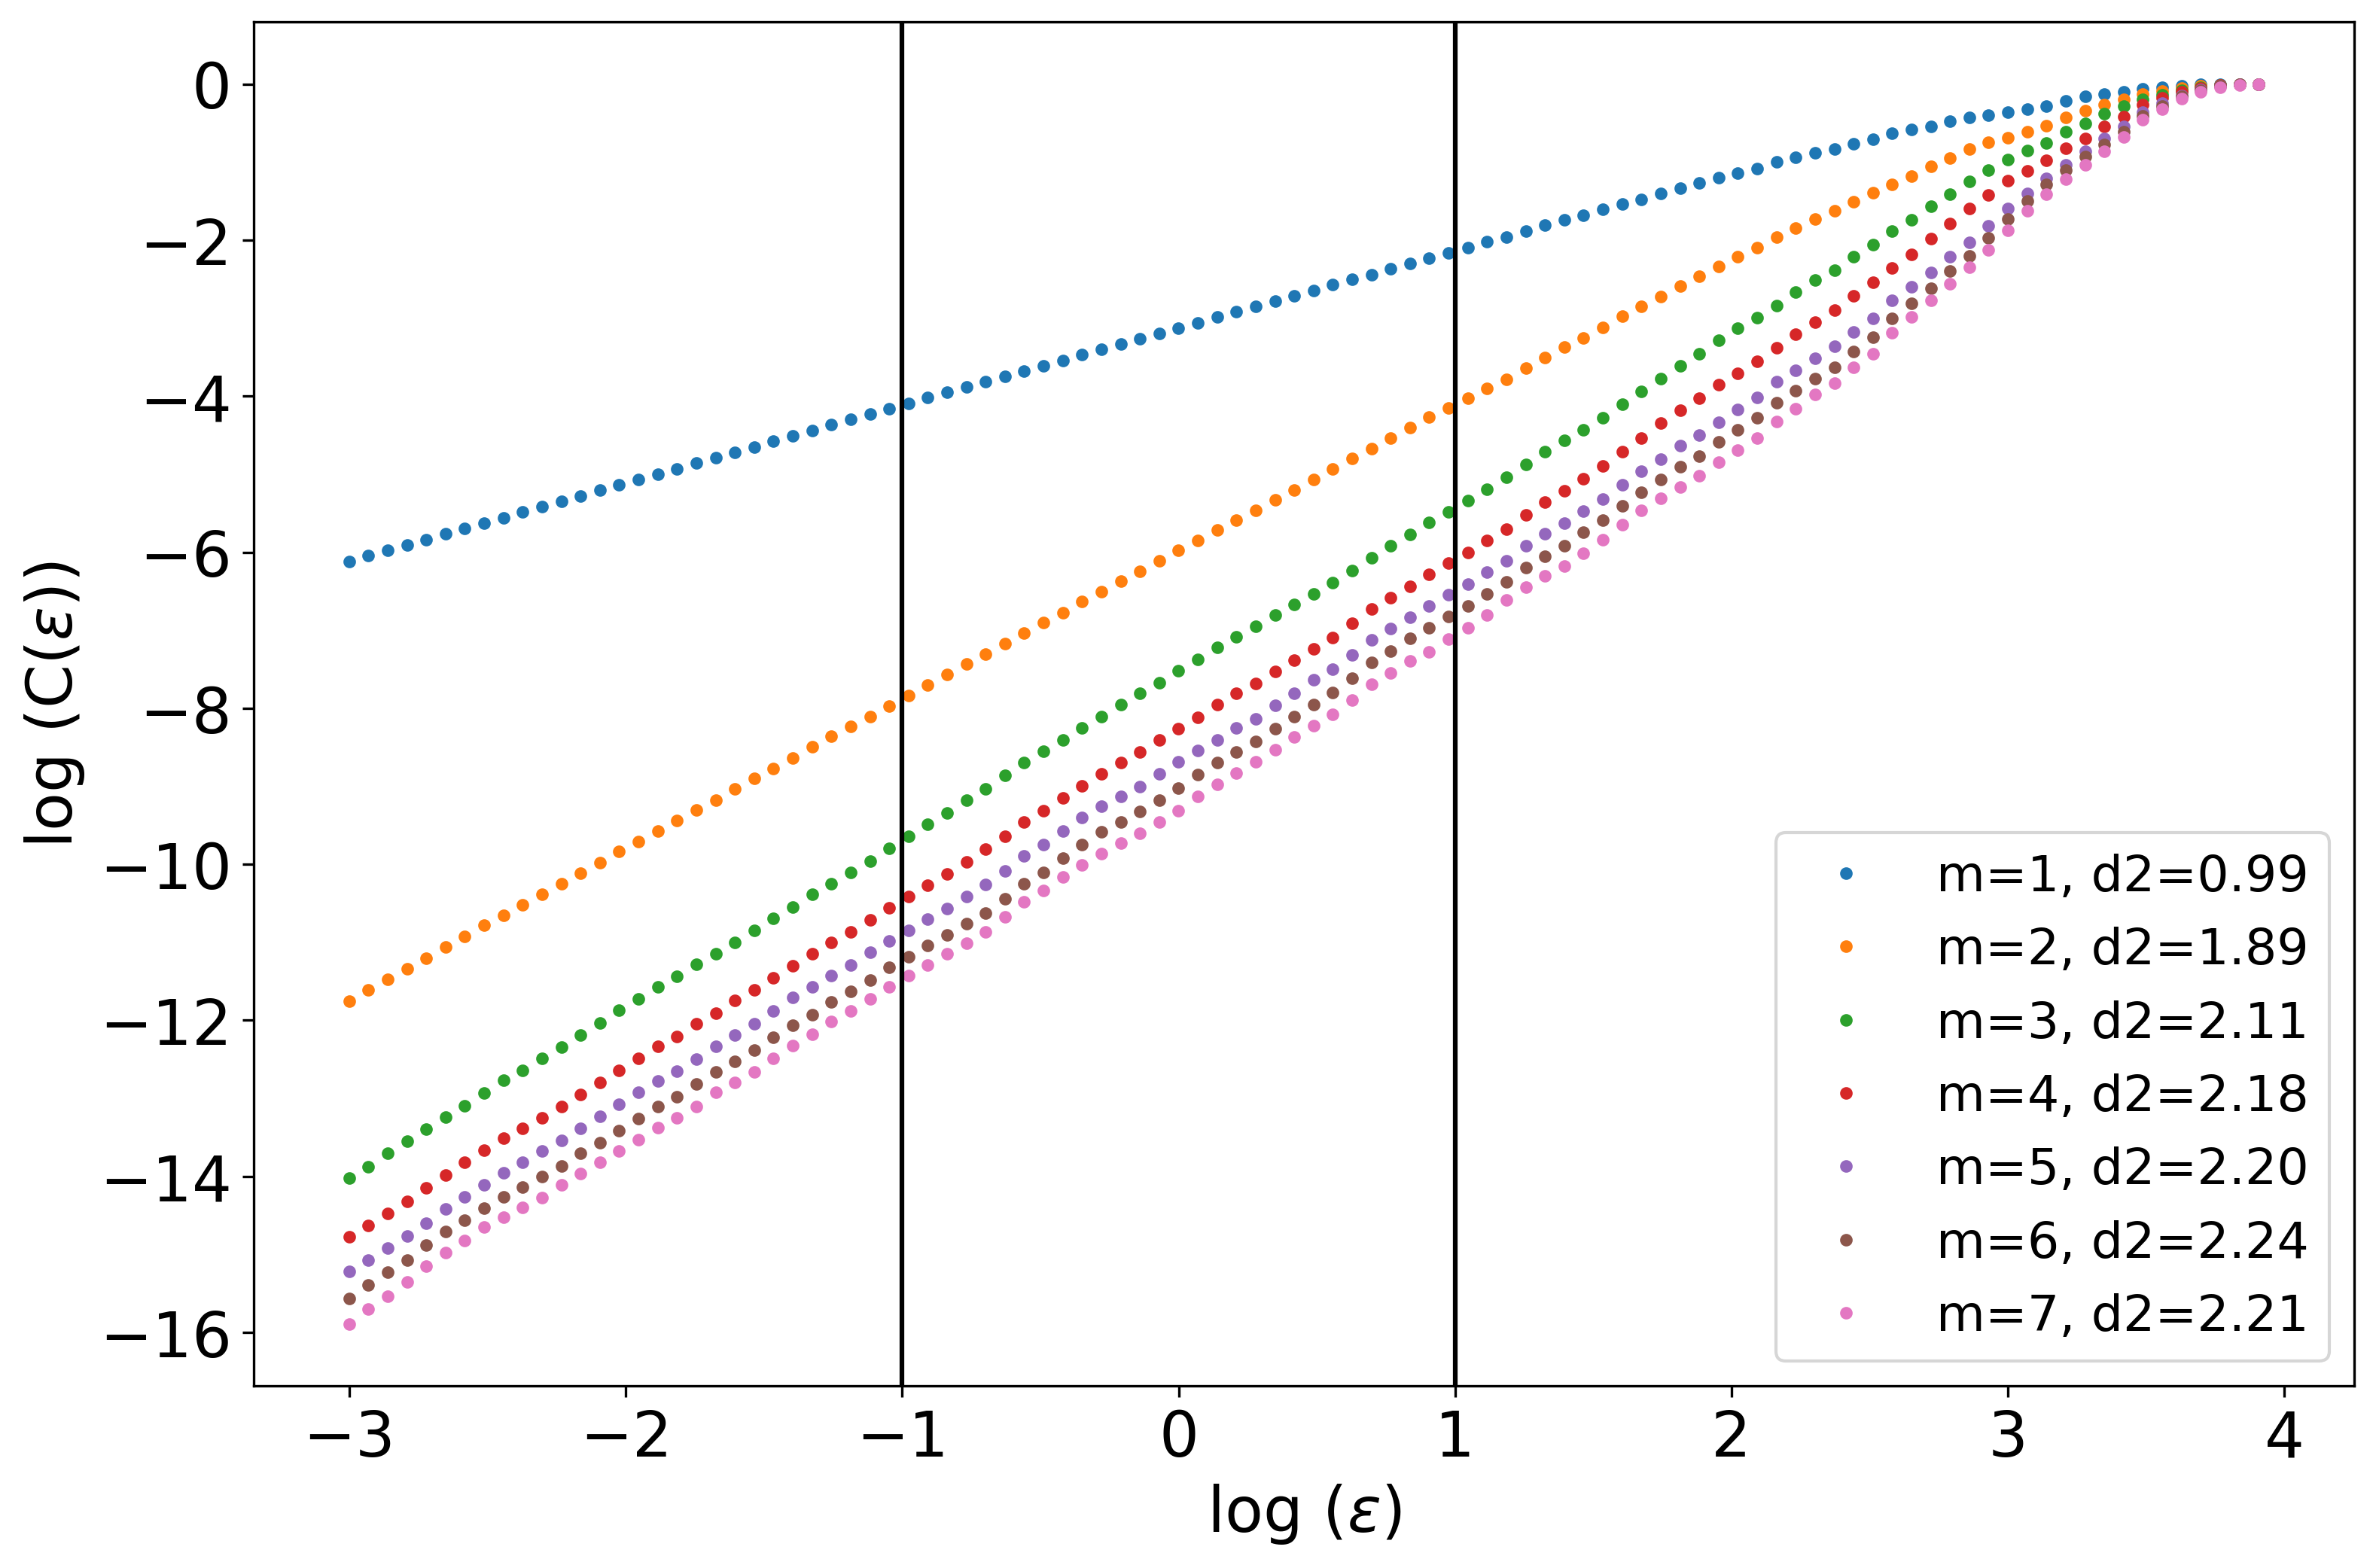

[-1, 1]
embedding dim=1, correlation dimension=0.9866603922842304+/-0.000494825707689059
embedding dim=2, correlation dimension=1.8866727851679084+/-0.0016663466213126701
embedding dim=3, correlation dimension=2.1134332873547232+/-0.0065979786977220884
embedding dim=4, correlation dimension=2.1790244071394493+/-0.007095597294679395
embedding dim=5, correlation dimension=2.1976295875513188+/-0.009259670353255268
embedding dim=6, correlation dimension=2.239464470492182+/-0.009019299339100291
embedding dim=7, correlation dimension=2.2133922882701036+/-0.008784587372845177


In [31]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]

#series = data_lorenz(0)
print(step_size)
#tau = 125
tau = 250
dims = 7

#plt.figure()
#plt.plot(x[:-tau], x[tau:], '.', markersize=.1)
#plt.xlabel(r'$\omega_{t}$', fontsize=12)
#plt.ylabel(r'$\omega_{t+\tau}$', fontsize=12)
#plt.savefig('chaotic_pendulum_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

#limits=[1,3]
#theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
#print(theiler_window)
#corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t', theiler_window, data=x, silent=True)
#c2 = corr[0]['c2']
#log_c2 = np.log(c2)
#plot_d2_with_slopes(log_c2, dims, 'chaotic_pendulum_mutual_tau_{}_ds_rate_{}_1.png'.format(tau, ds_rate), limits)

limits=[-1,1]
theiler_window = int(2.718**limits[-1]/step_size/ds_rate) * theiler_multiplier
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t', theiler_window, data=x, silent=True)
c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2_with_slopes(log_c2, dims, './d2_figures_paper/chaotic_pendulum_mutual_tau_{}_ds_rate_{}_limits_{}_{}.png'.format(tau, ds_rate, limits[0], limits[1]), limits)
#plot_d2(log_c2, dims, '/tmp/pendulum_mutual_tau_450.png', limits)
fit_slopes(log_c2, dims, limits)

0.001
2718
Additional non-data files were created
1 0.9862283191409145
2 1.8927582222632575
3 2.2364182109551236
4 2.2171856531678817
5 2.179024183961439
6 2.1855375017278007
7 2.1791640066088553


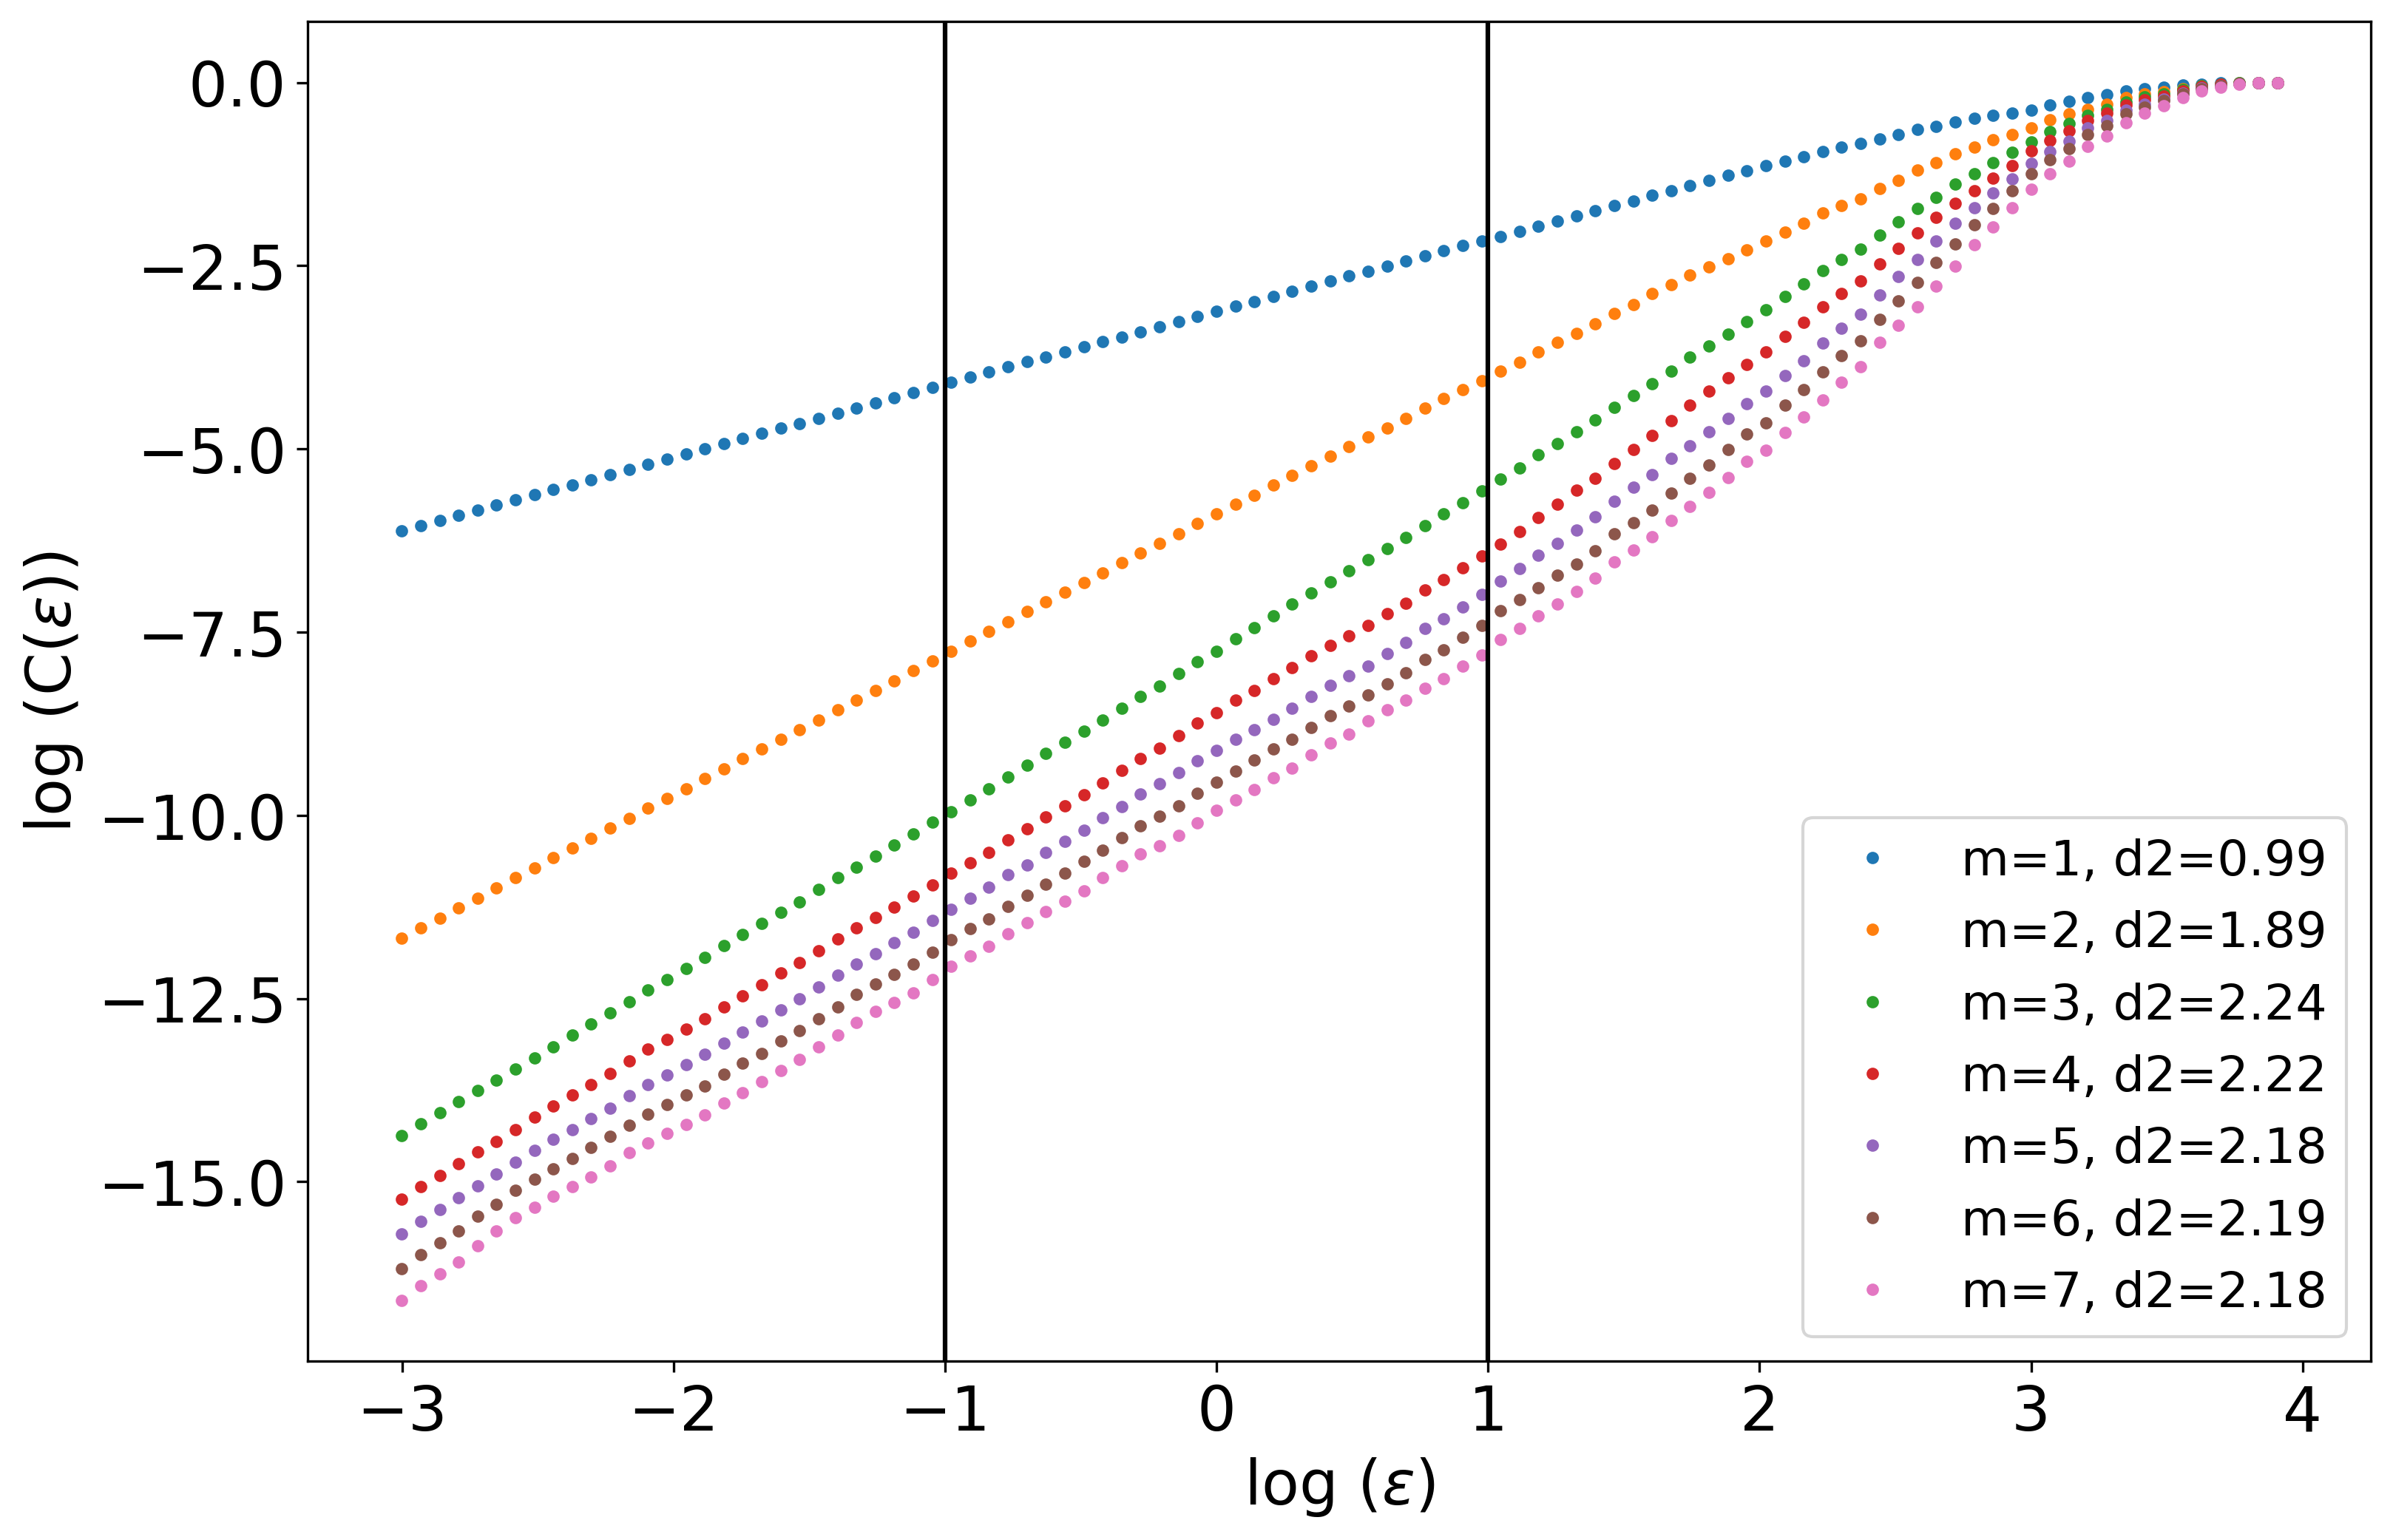

[-1, 1]
embedding dim=1, correlation dimension=0.9862283191409145+/-0.0005314925398944952
embedding dim=2, correlation dimension=1.8927582222632575+/-0.0022594691053068757
embedding dim=3, correlation dimension=2.2364182109551236+/-0.0023725735240422356
embedding dim=4, correlation dimension=2.2171856531678817+/-0.005985796249625249
embedding dim=5, correlation dimension=2.179024183961439+/-0.006279175648690878
embedding dim=6, correlation dimension=2.1855375017278007+/-0.00428761340420699
embedding dim=7, correlation dimension=2.1791640066088553+/-0.004485191093298684


In [19]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]

#series = data_lorenz(0)
print(step_size)
#tau = 125
tau = 440
dims = 7

#plt.figure()
#plt.plot(x[:-tau], x[tau:], '.', markersize=.1)
#plt.xlabel(r'$\omega_{t}$', fontsize=12)
#plt.ylabel(r'$\omega_{t+\tau}$', fontsize=12)
#plt.savefig('chaotic_pendulum_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

#limits=[1,3]
#theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
#print(theiler_window)
#corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t', theiler_window, data=x, silent=True)
#c2 = corr[0]['c2']
#log_c2 = np.log(c2)
#plot_d2_with_slopes(log_c2, dims, 'chaotic_pendulum_mutual_tau_{}_ds_rate_{}_1.png'.format(tau, ds_rate), limits)

limits=[-1,1]
theiler_window = int(2.718**limits[-1]/step_size/ds_rate) * theiler_multiplier
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t', theiler_window, data=x, silent=True)
c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2_with_slopes(log_c2, dims, './d2_figures_paper/corr/chaotic_pendulum_mutual_tau_{}_ds_rate_{}_limits_{}_{}.png'.format(tau, ds_rate, limits[0], limits[1]), limits)
#plot_d2(log_c2, dims, '/tmp/pendulum_mutual_tau_450.png', limits)
fit_slopes(log_c2, dims, limits)

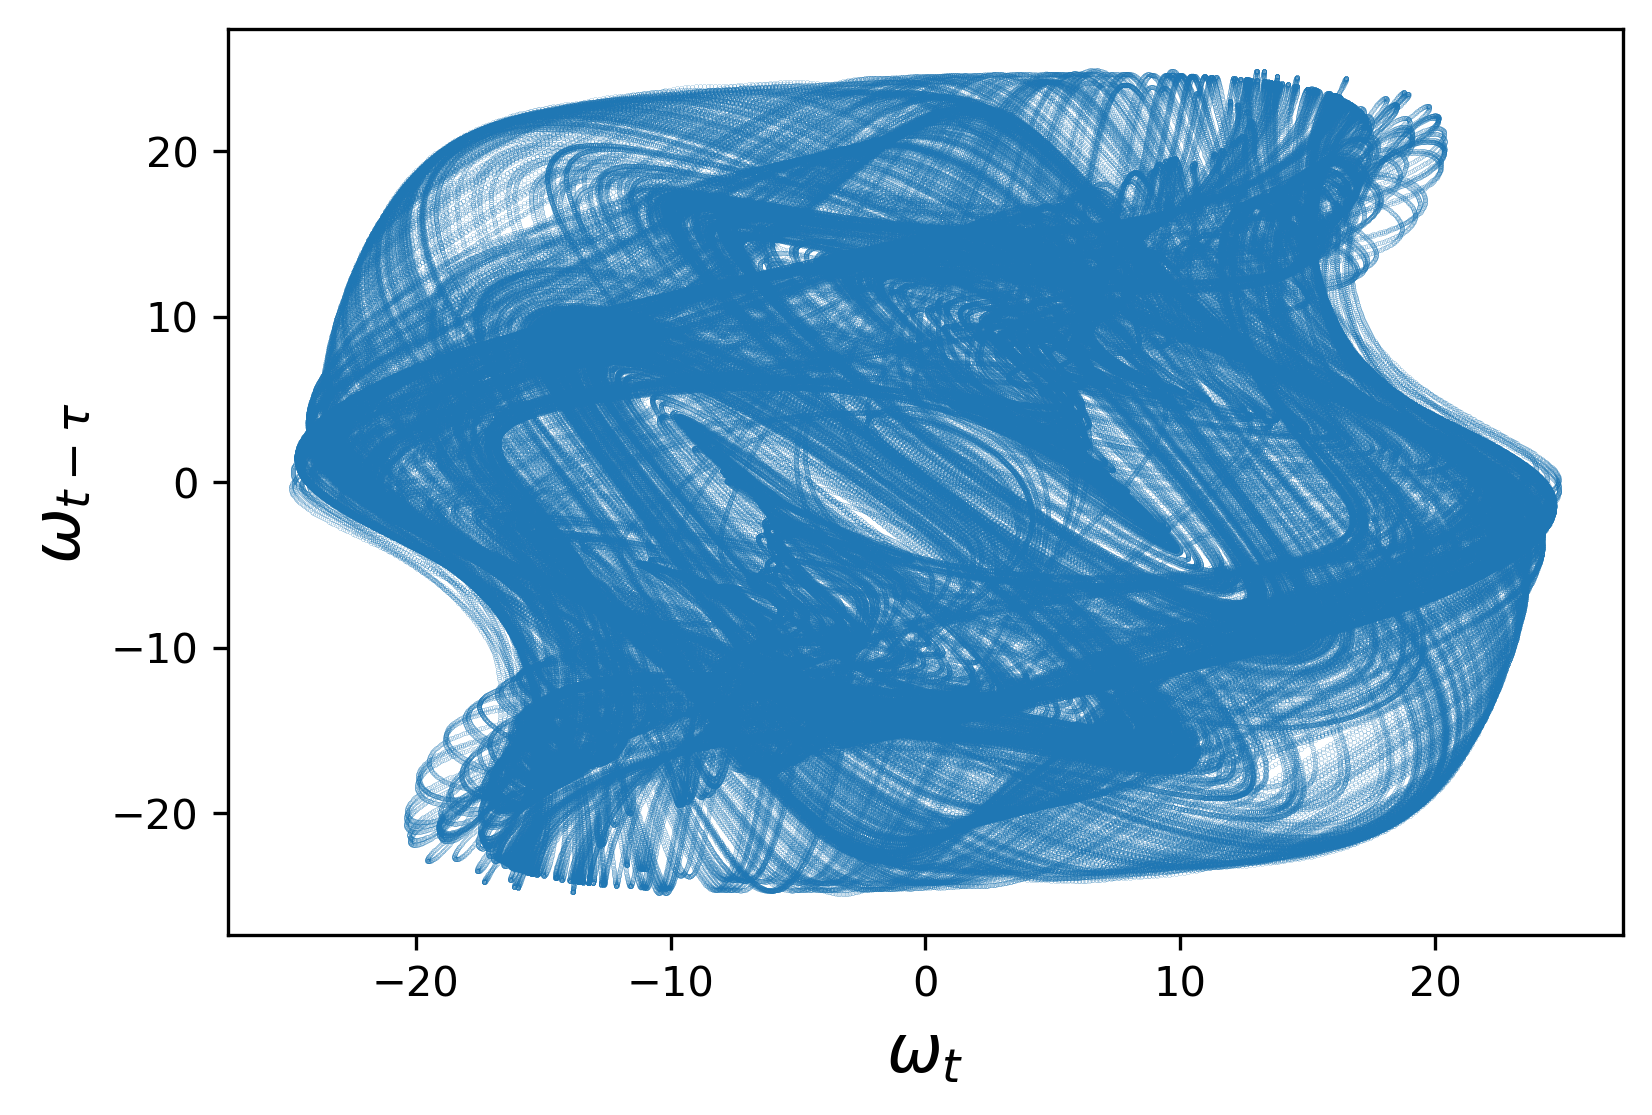

In [17]:
tau = 250
plt.figure(dpi=300)#, figsize=(12,12))
plt.plot(x[tau:], x[:-tau], '.', markersize=.1)
plt.xlabel(r'$\omega_{t}$', fontsize=16)
plt.ylabel(r'$\omega_{t-\tau}$', fontsize=16)
plt.savefig('d2_figures_paper/chaotic_pendulum_reconstruction_tau_{}.png'.format(tau))

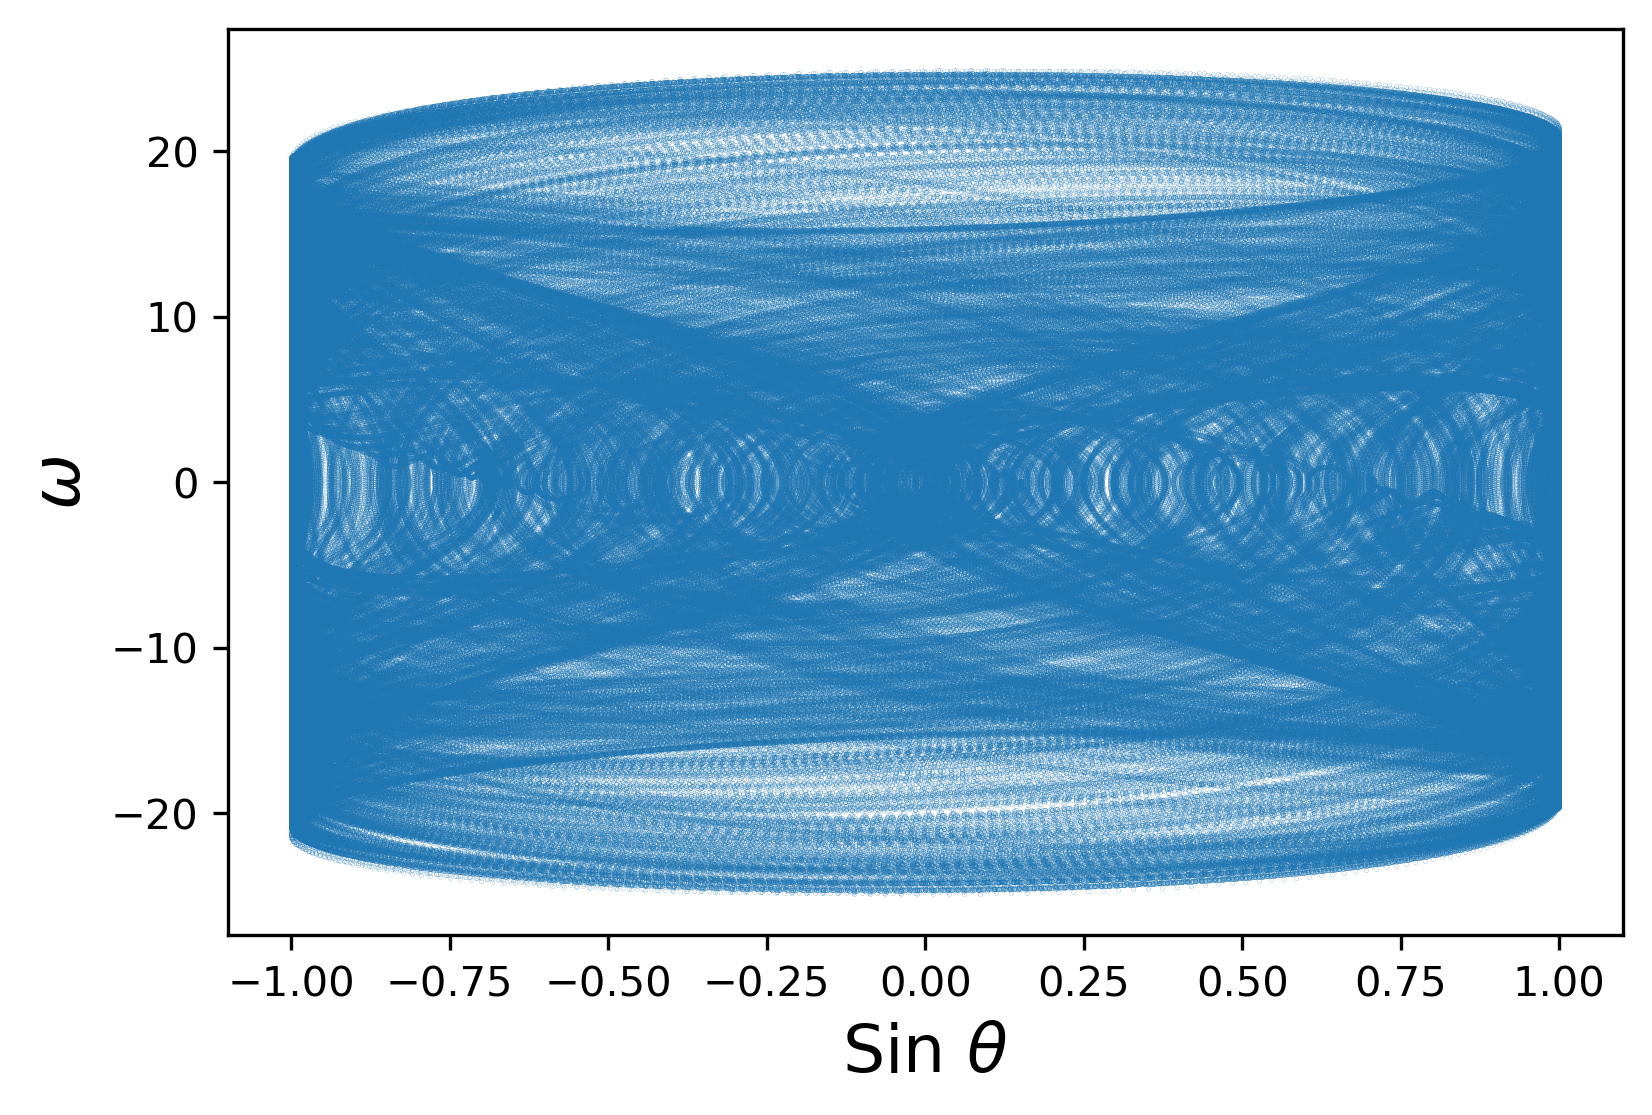

In [159]:
plt.figure(dpi=300)
plt.plot(np.sin(data[:,0]), data[:,1], '.', markersize=.1)
plt.xlabel(r'Sin $\theta$', fontsize=16)
plt.ylabel(r'$\omega$', fontsize=16)
plt.savefig('d2_figures_paper/chaotic_pendulum_full.png')

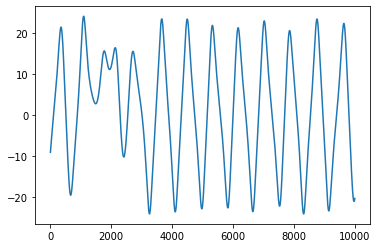

In [119]:
start = 0
plt.plot(x[start:start+10000])